# Ex 14: Fast track to the Moon

Our goal is to transfer from a parking orbit to the moon. It is possible to use a Hohmann transfer orbit, however, even it is often use because it requires the least amount of impulse, it is also the slowest. To improve the transfer time, an other arbitary point (not the periapsis of the future orbit) could be use as impulse point. In this case, the orbit after the impulse is characterise by the polar coordinates of the burn and its angle.

In [442]:
from space_base import GravBody, Probe
import matplotlib.pyplot as plt
import numpy as np

# Constants
G = 6.67e-11  # Gravitational constant
earth = GravBody.earth()  # Earth as an object with mass and radius

The initial given condition are:

- Speed after burn $V_0=10.85kms^{-1}$
- Altitude $z_0=300km$
- Angle $\psi_0=6°$ (angle between $\vec{V}$ and $\hat{\theta}$ ($\hat{\theta}\perp\vec{r}$))

In [443]:
z0 = 300e3  # Initial altitude
r0 = earth.radius + z0  # Initial distance from center of Earth
v0 = 10.85e3  # Initial velocity
psi0 = np.deg2rad(6) # Initial angle
r_moon = 384_400e3

# Initial position and velocity vectors
xy0 = [-r0, 0] # Start at left of the graph
vxy0 = [-v0*np.sin(psi0), -v0*np.cos(psi0)]

Knowing this, it is possible to calculate the specific energy $\epsilon$ using:

$$\epsilon=-\frac{GM_{earth}}{2a}=\frac{1}{2}V^2-\frac{GM_{earth}}{r}$$

And the specific angular momentum $h$,

$$h=r^2\dot{\theta}=r_0v_0\cos(\psi_0)$$

In [444]:
energy0 = 0.5*v0**2-(G*earth.mass)/r0
energy0 # Initial energy (should be constant throughout the simulation)

-851797.5191125795

In [445]:
h0 = r0*v0*np.cos(psi0) 
h0 / 1e6 # Initial angular momentum (km^2/s)

71983.84286941901

Then, the semi-major axis can be calculate from the previous energy equation.

$$a=-\frac{GM_{earth}}{2\epsilon}$$

In [446]:
a = -G*earth.mass/(2*energy0)
a / 1e3 # Semi-major axis (km)

233826.54390388748

Finally, it is possible to use the polar equation of the orbit to find the eccentricity:

$$r=\frac{a(1-e^2)}{1+e\cos(\theta)}$$
$$ae^2+er\cos(\theta)+r-a=0$$

Hence,

$$\Delta=(r\cos(\theta))^2-4a(r-a)$$
$$e=\frac{-r\cos(\theta)\pm\sqrt\Delta}{2a}$$

In [447]:
discriminant = r0**2 - 4*a*(r0-a)
em = (-r0+np.sqrt(discriminant))/(2*a)
ep = (-r0-np.sqrt(discriminant))/(2*a)
e = max(em, ep) # Eccentricity
e

0.971470304916528

Finally, the time of traveling from a point $(r_0,\theta_0)$ to an other point $(r_0,\theta_1)$ is given using the flight time formula:

$$t(r)=\frac{GM_{earth}}{(-2\epsilon)^{3/2}}\left[\sin^-1(\left\{\frac{GM_{earth}+2\epsilon r}{\sqrt{(GM_{earth})^2+2\epsilon h^2}}\right\})-\left\{\frac{\sqrt{2\epsilon(h^2-2GM_{earth}r-2\epsilon r^2)}}{GM_{earth}}\right\}\right]$$

Hence, the transfer time should be $t(r_1)-t(r_0)$

Additionally, because we want that the angle increase as the distance r increase we need to add some modification on the $sin^-1$ block. First, result of the funcion is expected to be on the range $[-\frac{\pi}{2};\frac{\pi}{2}]$, it is needed to switch it to $[0; \pi]$. Secondly, $\frac{GM_{earth}+2\epsilon r}{\sqrt{(GM_{earth})^2+2\epsilon h^2}}$ is decreasing as r increase. Therefore, it is needed to invert it so that the inverted sin function will increase as r increase.

In [448]:
def flight_time(r):
    A = np.arcsin(-(G*earth.mass+2*energy0*r)/np.sqrt((G*earth.mass)**2+2*energy0*h0**2)) + np.pi/2
    B = np.sqrt(2*energy0*(h0**2-2*G*earth.mass*r - 2*energy0*r**2))/(G*earth.mass)
    return (G*earth.mass/(-2*energy0)**1.5) * (A - B)

# Time of flight
travel_time = abs(flight_time(r_moon) - flight_time(r0))
travel_time / (24*3600) # Time of flight in days

3.2483424316374734

In [449]:
def probeqns(_, posvel):
    r = np.sqrt(posvel[0] ** 2 + posvel[1] ** 2)
    f = -G * earth.mass / r ** 3
    gravity_force = f * posvel[0:2]
    axy = gravity_force

    return posvel[2], posvel[3], axy[0], axy[1]

probe = Probe(probeqns, travel_time, travel_time / 60, x0=xy0[0], vx0=vxy0[0], 
            y0=xy0[1], vy0=vxy0[1]) # probe as an object
t, posvel = probe.odesolve() # solve the differential equations

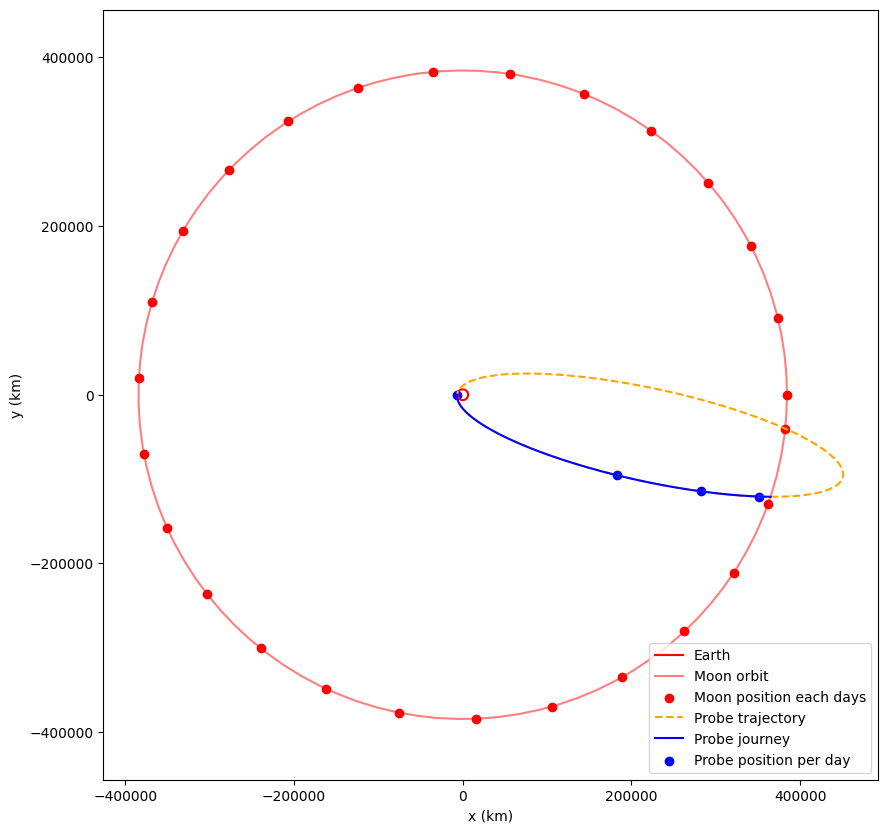

In [450]:
# Plot the trajectory
plt.figure(figsize=(10,10))

# Plotting Earth
uang = np.linspace(0, 2 * np.pi, 100)
x = (earth.radius / 1e3) * np.cos(uang)
y = (earth.radius / 1e3) * np.sin(uang)
plt.plot(x, y, color='red', label='Earth')
# Moon orbit
x = (r_moon / 1e3) * np.cos(uang)
y = (r_moon / 1e3) * np.sin(uang)
plt.plot(x, y, color="red", label='Moon orbit', alpha=0.5)
moon_day_period = np.sqrt(4*np.pi**2*r_moon**3/(G*earth.mass)) / (24*3600)
day_angle = 2*np.pi / moon_day_period
moon_days_round = np.floor(moon_day_period) 
uang = np.linspace(0, moon_days_round * day_angle, int(moon_days_round))
x = (r_moon / 1e3) * np.cos(uang)
y = (r_moon / 1e3) * np.sin(uang)
plt.scatter(x, y, color="red", label='Moon position per days')

# Plotting entire orbit
probe = Probe(probeqns, travel_time*4, travel_time*4 / 60, x0=posvel[-1, 0], vx0=posvel[-1, 2], 
            y0=posvel[-1, 1], vy0=posvel[-1, 3]) # probe as an object
t_after, posvel_after = probe.odesolve() # solve the differential equations
plt.plot(posvel_after[:, 0] / 1e3, posvel_after[:, 1] / 1e3, color='orange', linestyle="--", label="Probe trajectory") # plot the probe's orbit

plt.plot(posvel[0:, 0] / 1e3, posvel[0:, 1] / 1e3, color='blue', label="Probe journey") # plot the probe's orbit
plt.scatter(posvel[0::60*24, 0] / 1e3, posvel[0::60*24, 1] / 1e3, color='blue', label="Probe position per day") # plot the probe's orbit

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.axis('equal')
plt.legend()
plt.show() # make plot appear

In [451]:
r = np.sqrt(posvel_after[:, 0] ** 2 + posvel_after[:, 1] ** 2) # distance from the center of the Earth
r_per = np.min(r) # perigee
r_ap = np.max(r) # apogee
r_per / 1e3, r_ap / 1e3 # in km

(6599.827350109479, 461056.0972096128)

After the simulation we can check that real values match previous calculation.

In [452]:
a_real = (r_per + r_ap) / 2 # real semi-major axis
a_real / 1e3, (a - a_real) / 1e3 # in km

(233827.96227986112, -1.4183759736418724)

In [453]:
e_real = (r_ap - r_per) / (r_ap + r_per) # real eccentricity
e_real, e - e_real

(0.9717748583798103, -0.0003045534632822866)

## Comparing to Hohmann transfer

To compare our previous result we will assume a Hohmann transfer starting at an altitude 300km and with an apoapsis matching moon orbit altitude.

In [454]:
r_per = r0
r_ap = r_moon
a = (r_per + r_ap) / 2
e = (r_ap - r_per) / (r_ap + r_per)
journey_time = np.sqrt(4 * np.pi**2 * a**3 / (G * earth.mass)) / 2
journey_time / (24*3600) # Time of flight in days

4.981320278873557

The transfer time using an Hohmann transfer is greater than the previous technique. To better understand the difference it can be interesting to plot the two trajectories.

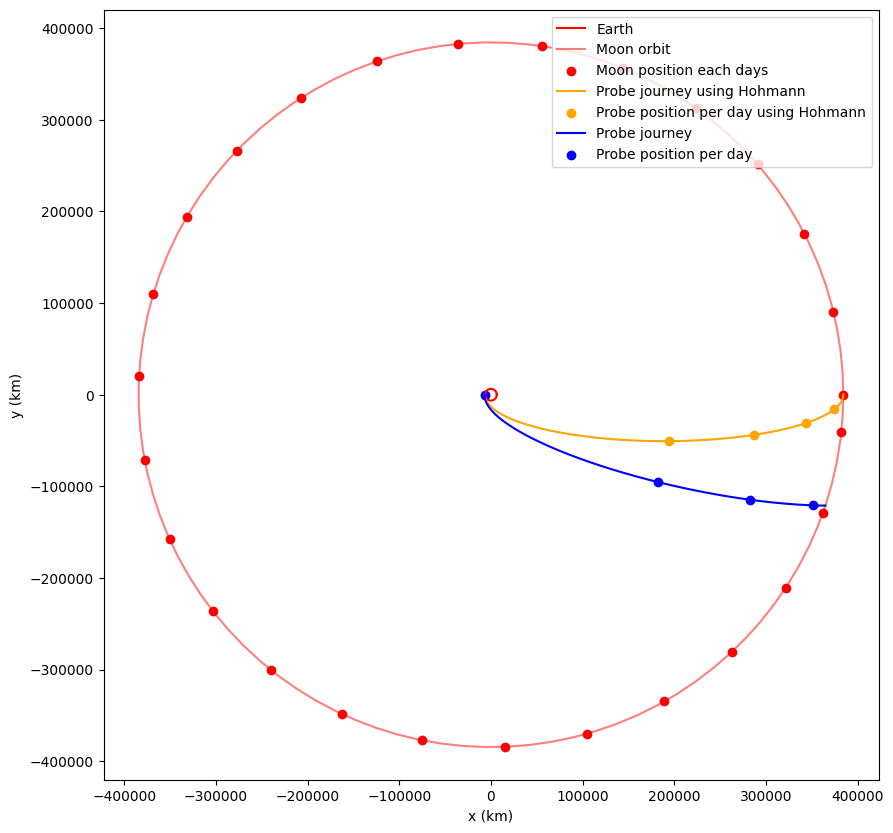

In [455]:
xy0 = [-r0, 0] # Start at left of the graph
v0 = np.sqrt(G * earth.mass * (2 / r_per - 1 / a))
vxy0 = [0, -v0]

probe = Probe(probeqns, journey_time, journey_time / 60, x0=xy0[0], vx0=vxy0[0], 
            y0=xy0[1], vy0=vxy0[1]) # probe as an object
t_hohmann, posvel_hohmann = probe.odesolve() # solve the differential equations

# Plot the trajectory
plt.figure(figsize=(10,10))

# Plotting Earth
uang = np.linspace(0, 2 * np.pi, 100)
x = (earth.radius / 1e3) * np.cos(uang)
y = (earth.radius / 1e3) * np.sin(uang)
plt.plot(x, y, color='red', label='Earth')
# Moon orbit
x = (r_moon / 1e3) * np.cos(uang)
y = (r_moon / 1e3) * np.sin(uang)
plt.plot(x, y, color="red", label='Moon orbit', alpha=0.5)
moon_day_period = np.sqrt(4*np.pi**2*r_moon**3/(G*earth.mass)) / (24*3600)
day_angle = 2*np.pi / moon_day_period
moon_days_round = np.floor(moon_day_period) 
uang = np.linspace(0, moon_days_round * day_angle, int(moon_days_round))
x = (r_moon / 1e3) * np.cos(uang)
y = (r_moon / 1e3) * np.sin(uang)
plt.scatter(x, y, color="red", label='Moon position per days')

plt.plot(posvel_hohmann[0:, 0] / 1e3, posvel_hohmann[0:, 1] / 1e3, color='orange', label="Probe journey using Hohmann") # plot the probe's orbit
plt.scatter(posvel_hohmann[0::60*24, 0] / 1e3, posvel_hohmann[0::60*24, 1] / 1e3, color='orange', label="Probe position per day using Hohmann") # plot the probe's orbit

plt.plot(posvel[0:, 0] / 1e3, posvel[0:, 1] / 1e3, color='blue', label="Probe journey") # plot the probe's orbit
plt.scatter(posvel[0::60*24, 0] / 1e3, posvel[0::60*24, 1] / 1e3, color='blue', label="Probe position per day") # plot the probe's orbit

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.axis('equal')
plt.legend(loc='upper right')
plt.show() # make plot appear